This notebook contains all the code needed to reproduce the results from the thesis "Voting systems at the Eurovision Song Contest", authored my me (Lennart Beekhuis, University of Amsterdam) and supervised by Arthur Boixel and Ulle Endriss.

## Contents

1. Object-oriented classes
2. Importing data into the class format
3. Contest class and importing data for post-2015 contests
4. Applying different rules to an ESC
5. Finding a score vector which makes a certain country win
6. Determining the effect of collusion on a country's rankings

## Object-oriented classes

First, a Contest class was made. The Contest class contains other class objects: Country objects, and one Rule object. To compute a score, it loops over all the Country objects, takes their rankings, applies the specified scoring vector on it and adds the scores up. Using this, we can apply a different rule to an ESC than the original rule used.

In [1]:
import os
import random

class Country():
    """Country class which specifies the ranking of a country and its abbreviation."""
    def __init__(self, country, ranking_list, score_vector=None):
        self.country = country
        self.ranking_list = ranking_list
        self.score_vector = score_vector
        
    def get_country_name(self):
        return self.country

    def get_ranking_list(self):
        return self.ranking_list
    
    def get_score_vector(self):
        return self.score_vector

    def get_ith_ranking(self, i):
        return self.ranking_list[i-1]
    
class Rule():
    """Rule class consisting of a scoring vector and a vector length.
    Scoring vector is specified from largest to smallest score."""
    def __init__(self, scoring_vector, vector_length):
        self.scoring_vector = scoring_vector
        self.vector_length = vector_length

    def get_scoring_vector(self):
        return self.scoring_vector

    def get_vector_length(self):
        return self.vector_length

class Contest():
    """Contest class includes everything to compute the original outcome
    of a certain year's ESC. Later will also be able to solve the problem(s)
    specified in the thesis proposal."""
    def __init__(self, country_list, voting_rule):
        self.country_list = country_list
        self.removed_list = []
        self.voting_rule = voting_rule
        self.nr_of_countries = len(country_list)
        
    def compute_result(self, rule=None):
        """Outputs a dict with as key the country and as value the final score
        of that country.
        If a rule is specified, computes the result using that rule instead of
        the rule specified in the Contest object."""
        result = dict()
        if rule is None and self.voting_rule is None:
            result = self.compute_result_non_linear()
            return result
        
        elif rule is None:
            rule_vector = self.voting_rule.get_scoring_vector()
            rule_length = self.voting_rule.get_vector_length()
        else:
            rule_vector = rule.get_scoring_vector()
            rule_length = rule.get_vector_length()
        
        for country in self.country_list:
            # this part of the code is used for contests after 2015.
            # They use a different class which will be specified later.
            if isinstance(country, Country2015) and rule is None:
                jury_list = country.get_ranking_list_jury()
                tele_list = country.get_ranking_list_tele()

                rank = 0
                for c in jury_list:
                    if rank + 1 > rule_length:
                        break
                    if c not in result:
                        result[c] = 0
                    result[c] += rule_vector[rank]
                    rank += 1

                rank = 0
                for c in tele_list:
                    if rank + 1 > rule_length:
                        break
                    if c not in result:
                        result[c] = 0
                    result[c] += rule_vector[rank]
                    rank += 1
            else:
                ranking_list = country.get_ranking_list()
                rank = 0
                for c in ranking_list:
                    if rank + 1 > rule_length:
                        break
                    if c not in result:
                        result[c] = 0
                    result[c] += rule_vector[rank]
                    rank += 1

        return result
    
    def compute_result_non_linear(self):
        result = dict()
        for country in self.country_list:
            rank = 0
            ranking_list = country.get_ranking_list()
            score_vector = country.get_score_vector()
            for c in ranking_list:
                if c not in result:
                    result[c] = 0
                result[c] += score_vector[rank]
                rank += 1
        return result

    def print_result(self, rule=None):
        """Prints the result in a ranking list format."""
        result = self.compute_result(rule)
        for element in sorted(result, key=result.get, reverse=True):
            print(element, result[element])
        print()

## Importing data into the class format

Before we can compute anything, we need to import the data first. Make sure the 'votes.csv' is in the same directory as this notebook, otherwise import_scores_linear_only() won't work.

In [2]:
import csv

def import_scores_linear_only(first_year, last_year, file_name = 'votes.csv'):
    """ HARDCODED FUNCTION
    Reads and puts the rankings of each country in the finals
    from first_year to last_year in a dictionary. This dict has 2 levels:
    Top level: key = year, value = dict of participating countries
    Bottom level: key = country, value = ranked list of preferences
    NOTE: this function only works for linear rankings, and doesn't work
    with post-2015 rankings."""
    f = open(file_name, "r")
    ff = csv.reader(f)

    ESC = dict()
    for year in range(first_year, last_year):
        ESC[str(year)] = dict()

    for row in ff:
        if row[0] == 'year':
            continue
        if int(row[0]) not in range(first_year, last_year) or row[1] != 'final' or row[6] == '0':
            continue
        if row[2] not in ESC[row[0]]:
            ESC[row[0]][row[2]] = dict()
        ESC[row[0]][row[2]][row[3]] = int(row[6])
        
    scores_to_rankings(ESC)
    return ESC

def import_scores_non_linear(first_year, last_year, file_name = 'votes.csv'):
    """placeholder"""
    f = open(file_name, "r")
    ff = csv.reader(f)
    
    ESC = dict()
    for year in range(first_year, last_year):
        ESC[str(year)] = dict()
    
    for row in ff:
        if row[0] == 'year':
            continue
        if int(row[0]) not in range(first_year, last_year) or row[1] != 'final' or row[6] == '0':
            continue
        if row[2] not in ESC[row[0]]:
            ESC[row[0]][row[2]] = dict()
        ESC[row[0]][row[2]][row[3]] = int(row[6])
        
    vector_dict = scores_to_rankings_non_linear(ESC)
    return ESC, vector_dict

def scores_to_rankings(ESC_dict):
    """This is a helper function for import_scores_linear_only.
    It turns lists of (country, score) tuples into a ranked list of preferences."""
    for year in ESC_dict:
        for country in ESC_dict[year]:
            score_dict = ESC_dict[year][country]
            ranking_list = []
            for scored_country in sorted(score_dict, key=score_dict.get, reverse=True):
                ranking_list.append(scored_country)
            ESC_dict[year][country] = ranking_list
    pass

def scores_to_rankings_non_linear(ESC_dict):
    """placeholder"""
    vector_dict = dict()
    for year in ESC_dict:
        vector_dict[year] = dict()
        for country in ESC_dict[year]:
            score_dict = ESC_dict[year][country]
            ranking_list = []
            score_list = []
            for scored_country in sorted(score_dict, key=score_dict.get, reverse=True):
                ranking_list.append(scored_country)
                score_list.append(score_dict[scored_country])
            ESC_dict[year][country] = ranking_list
            vector_dict[year][country] = score_list
            
    return vector_dict
            

def dict_to_classes(d, scoring_rule):
    """Takes as input a dict outputted by import_scores_linear_only() and a scoring rule,
    and returns a dict with objects of class Contest."""
    ESC_objects = dict()
#     for year in range(1975,2016):
#         ESC_objects[str(year)] = None
        
    for year in d:
        country_list = []
        for country in d[year]:
            new_country = Country(country, d[year][country])
            country_list.append(new_country)
        ESC_objects[year] = Contest(country_list, scoring_rule)
    
    return ESC_objects

def dict_to_classes_non_linear(d, vector_d):
    """Placeholder"""
    ESC_objects = dict()
    # ???
        
    for year in d:
        country_list = []
        for country in d[year]:
            new_country = Country(country, d[year][country], score_vector=vector_d[year][country])
            country_list.append(new_country)
        ESC_objects[year] = Contest(country_list, None)
    
    return ESC_objects

In [3]:
ESC, vector_dict = import_scores_non_linear(1967,1975)
ESC_1967_75 = dict_to_classes_non_linear(ESC, vector_dict)
for year in ESC_1967_75:
    ESC_1967_75[year].print_result()


gb 47
ie 22
fr 20
lu 17
mc 10
es 9
be 8
de 7
yu 7
se 7
it 4
pt 3
fi 3
nl 2
no 2
at 2

es 29
gb 28
fr 20
ie 18
se 15
de 11
yu 8
mc 8
be 8
it 7
lu 5
pt 5
at 2
no 2
ch 2
nl 1
fi 1

es 18
nl 18
gb 18
fr 18
ch 13
mc 11
ie 10
be 10
de 8
se 8
lu 7
fi 6
yu 5
it 5
pt 4
no 1

ie 32
gb 26
de 12
ch 8
fr 8
es 8
nl 7
mc 5
be 5
it 5
yu 4

mc 128
es 116
de 100
gb 98
it 91
se 85
nl 85
fi 84
pt 83
fr 82
ie 79
ch 78
lu 70
yu 68
be 68
at 66
no 65
mt 52

lu 128
gb 114
de 107
nl 106
at 100
it 92
pt 90
ch 88
yu 87
es 83
fr 81
fi 78
se 75
no 73
ie 72
mc 65
be 55
mt 48

lu 129
es 125
gb 123
il 97
se 94
fi 93
no 89
de 85
mc 85
ie 80
pt 80
ch 79
it 74
nl 69
yu 65
fr 65
be 58

se 24
it 18
nl 15
mc 14
gb 14
lu 14
il 11
ie 11
es 10
be 10
gr 7
yu 6
fi 4
no 3
de 3
ch 3
pt 3



## Contest class and importing data for post-2015 contests

The classes and functions specified only work for the contests until 2015. After 2015, the vote was split into two parts: a jury vote and a televote. To work with these contests, another Country class was made which inherits all the functions from the older Country class, and a new import function was created.

Note: make sure 'votes.csv' is in the same directory as this notebook.

In [4]:
class Country2015(Country):
    """Class object which handles contests after 2015. Inherits original
    Country functions. To compute the outcome, the jury and televoting
    ranking lists are used.
    To apply older rules to these contests, the jury and televoting
    ranking lists are combined into one ranking list using pre_2015_ify()"""
    def __init__(self, country, jury, tele, total, semifinal_score=0):
        self.country = country
        self.ranking_list_jury = jury
        self.ranking_list_tele = tele
        self.ranking_list = pre_2015_ify(jury, tele, total)
        self.semifinal_score = semifinal_score
        
    def get_ranking_list_jury(self):
        return self.ranking_list_jury
    
    def get_ranking_list_tele(self):
        return self.ranking_list_tele

def import_scores_2015_and_beyond(file_name = 'votes.csv'):
    """ HARDCODED FUNCTION
    Reads and puts the rankings of each country in the finals
    from 2016 to 2019 in three dictionaries. This dict has 2 levels:
    Top level: key = year, value = dict of participating countries
    Bottom level: key = country, value = ranked list of preferences
    ESC_jury and ESC_tele contain a linear ranking,
    ESC_total contains (country, score) tuples, obtained by
    adding up the jury score and the televoting score."""
    f = open(file_name, "r")
    ff = csv.reader(f)

    ESC_jury, ESC_tele, ESC_total = dict(), dict(), dict()

    for year in range(2016,2020):
        ESC_jury[str(year)], ESC_tele[str(year)] = dict(), dict()
        ESC_total[str(year)] = dict()

    for row in ff:
        if row[0] == 'year':
            continue
        if int(row[0]) not in range(2016,2020) or row[1] != 'final' or row[6] == '0':
            continue
        if row[2] not in ESC_jury[row[0]] and row[8] != 0:
            ESC_jury[row[0]][row[2]] = dict()
        if row[2] not in ESC_tele[row[0]] and row[7] != 0:
            ESC_tele[row[0]][row[2]] = dict()
        if row[2] not in ESC_total[row[0]]:
            ESC_total[row[0]][row[2]] = dict()
        if row[8] != 0:
            ESC_jury[row[0]][row[2]][row[3]] = int(row[8])
        if row[7] != 0:
            ESC_tele[row[0]][row[2]][row[3]] = int(row[7])
        ESC_total[row[0]][row[2]][row[3]] = int(row[6])

    scores_to_rankings(ESC_jury)
    scores_to_rankings(ESC_tele)

    return ESC_jury, ESC_tele, ESC_total

def pre_2015_ify(jury, tele, total, voting_rule=Rule([12,10,8,7,6,5,4,3,2,1], 10)):
    """Converts the post 2015 total score to a 1975-2012 ranking.
    To break ties, the jury vote is checked: the country which is
    ranked higher in the jury vote wins the tie."""
    result = dict()
    rule_vector = voting_rule.get_scoring_vector()
    rule_length = voting_rule.get_vector_length()
    
    def swap_positions(l, elem1, elem2):
        pos1, pos2 = l.index(elem1), l.index(elem2)
        l[pos1], l[pos2] = l[pos2], l[pos1] 
    
    def bubble_sort_tuple_list(l):
        for i in range(len(l) - 1):
            if l[i][1] == l[i + 1][1]:
                if tele.index(l[i+1][0]) < tele.index(l[i][0]):
                    swap_positions(tuple_list, tuple_list[i+1], tuple_list[i])
    
    pre_2015_ranking = []
    tuple_list = []
    
    for element in sorted(total, key=total.get, reverse=True):
        tuple_list.append((element, total[element]))
        
    for i in range(5):
        bubble_sort_tuple_list(tuple_list)
    
    ranking_list = []
    for i in range(len(tuple_list)):
        ranking_list.append(tuple_list[i][0])
        
    return ranking_list
        
def dicts_to_2015_classes(d_jury, d_tele, d_total, voting_rule):
    """Takes as input a jury and televoting dict outputted by
    import_scores_2015_and_beyond() and a scoring rule, 
    and returns a dict with objects of class Contest."""
    ESC_classified = dict()
    for year in range(2016,2020):
        ESC_classified[str(year)] = None

    for year in d_jury:
        country_list = []
        for country in d_jury[year]:
            new_country = Country2015(country,
                                      d_jury[year][country], 
                                      d_tele[year][country],
                                      d_total[year][country])
            country_list.append(new_country)
        ESC_classified[year] = Contest(country_list, voting_rule)

    return ESC_classified


## Applying different rules to an ESC

Everything is now in place to apply a different rule to ESCs. Below is some code which imports all relevant ESCs into dicts, prints results using the original rule, and prints results using a different rule.
These commands were used to acquire the results in the rules_and_winners.xlsx file. The table in that file is also included in the thesis itself.

In [5]:
# rules
rule_1962 = Rule([3,2,1], 3)
rule_1963 = Rule([5,4,3,2,1], 5)
rule_1964_66 = Rule([5,3,1], 3)
rule_1975_2015 = Rule([12,10,8,7,6,5,4,3,2,1], 10)

# dicts with contests
ESC, vector_dict = import_scores_non_linear(1957,1962)
ESC_1957_61 = dict_to_classes_non_linear(ESC, vector_dict)

ESC_1962_66 = dict_to_classes(import_scores_linear_only(1962, 1967), rule_1964_66)
ESC_1962_66['1962'].voting_rule = Rule([3,2,1], 3)
ESC_1962_66['1963'].voting_rule = Rule([5,4,3,2,1], 5)

ESC, vector_dict = import_scores_non_linear(1967,1975)
ESC_1967_75 = dict_to_classes_non_linear(ESC, vector_dict)

ESC_1975_2015 = dict_to_classes(import_scores_linear_only(1975, 2016), rule_1975_2015)

d_jury, d_tele, d_total = import_scores_2015_and_beyond()
ESC_2016_19 = dicts_to_2015_classes(d_jury, d_tele, d_total, rule_1975_2015)

# print original result
ESC_1957_61['1957'].print_result()
ESC_1962_66['1962'].print_result()
ESC_1975_2015['1975'].print_result()
ESC_2016_19['2016'].print_result()

# print result when using a different rule
ESC_1962_66['1962'].print_result(rule_1964_66)
ESC_1975_2015['1975'].print_result(rule_1963)
ESC_2016_19['2016'].print_result(rule_1962)

# This function was used to help construct the rules_and_winners.xlsx table
def print_result_multiple_ESCs(ESC_dict, rule):
    """Takes as input a dict of ESCs and a rule.
    Outputs the result for all the ESCs in the dict using the rule."""
    
    for contest in ESC_dict:
        print("### " + str(contest) + " ###")
        ESC_dict[contest].print_result(rule)
        
# print_result_multiple_ESCs(ESC_1975_2015, rule_1962)


nl 31
fr 17
dk 10
lu 8
de 8
it 7
gb 6
be 5
ch 5
at 3

fr 26
mc 13
lu 11
yu 10
gb 10
de 9
se 4
fi 4
it 3
no 2
ch 2
dk 2

nl 152
gb 138
it 115
fr 91
lu 84
ch 77
fi 74
se 72
ie 68
es 53
il 40
mt 32
yu 22
mc 22
be 17
pt 16
de 15
no 11
tr 3

ua 534
au 511
ru 491
bg 307
se 261
fr 257
am 249
pl 229
lt 200
be 181
mt 153
nl 153
at 151
il 135
lv 132
it 124
az 117
rs 115
hu 108
ge 104
cy 96
es 77
hr 73
gb 62
cz 41
de 11

fr 40
mc 20
lu 17
yu 15
gb 15
de 13
se 6
fi 6
it 4
no 3
ch 3
dk 2

nl 54
gb 46
it 34
fr 31
fi 21
lu 20
ch 18
se 16
ie 14
es 6
il 6
mt 5
pt 5
de 3
be 2
no 2
yu 2

ua 45
au 41
ru 30
se 21
bg 18
fr 15
am 14
rs 13
lt 10
lv 8
be 7
at 7
az 6
it 4
cy 3
ge 2
nl 2
hu 2
pl 1
hr 1
es 1
mt 1



## Finding a score vector which makes a certain country win

To find the score vector which makes country X win, the mystic package was used. The mystic framework provides a collection of optimization algorithms and tools that allows the user to more robustly (and easily) solve hard optimization problems. (source: https://pypi.org/project/mystic/)
To use mystic, download it by using pip3 or the provided link.

A system of inequalities is first created in the format specified by mystic. This system is then solved using the mystic solver. Note that this solver only outputs one solution. If you run the solver again, it may output a different solution.

In [8]:
import mystic.symbolic as ms

# class Contest(Contest):
    
#     def rankings_to_variable_lists(self):
#         """Loops over all the rankings. For each ranked country x, add
#         the corresponding variable to their dictionary value.
#         f.e. for country X ranked 1st by country Y, add the variable A
#         corresponding to 1st place to their dictionary value.
#         Returns a dictionary, key = country, value = list of variables."""
#         result = dict()
#         mapping = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
#         mapping = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
#         # A = 1st, B = 2nd, ..., J = 10th
        
#         for country in self.country_list:
#             result[country.get_country_name()] = []
#         for country in self.country_list:
#             rank = 0
#             for elem in country.get_ranking_list():
#                 result[elem].append(mapping[rank])
#                 rank += 1
                
#         return result

class Contest(Contest):
    
    
    
    def rankings_to_variable_lists(self):
        """Loops over all the rankings. For each ranked country x, add
        the corresponding variable to their dictionary value.
        f.e. for country X ranked 1st by country Y, add the variable A
        corresponding to 1st place to their dictionary value.
        Returns a dictionary, key = country, value = list of variables."""
        result = dict()
        # mapping = {'w1':0, 'w2':1, 'w3':2, 'w4':3, 'w5':4, 'w6':5, 'w7':6, 'w8':7, 'w9':8, 'w10':9}
        # A = 1st, B = 2nd, ..., J = 10th
        
        for country in self.country_list:
            result[country.get_country_name()] = [0 for i in range(10)]
        for country in self.country_list:
            rank = 0
            for elem in country.get_ranking_list():
                result[elem][rank] += 1
                rank += 1
                
        return result
    
def reimport_data():
    """This function needs to be run after the Contest class has been redefined.
    It reimports all the data using the new contest class so that new functions
    can be used."""
    ESC, vector_dict = import_scores_non_linear(1957,1962)
    ESC_1957_61 = dict_to_classes_non_linear(ESC, vector_dict)
    
    ESC_1962_66 = dict_to_classes(import_scores_linear_only(1962, 1967), rule_1964_66)
    ESC_1962_66['1962'].voting_rule = Rule([3,2,1], 3)
    ESC_1962_66['1963'].voting_rule = Rule([5,4,3,2,1], 5)
    
    ESC, vector_dict = import_scores_non_linear(1967,1975)
    ESC_1967_75 = dict_to_classes_non_linear(ESC, vector_dict)

    ESC_1975_2015 = dict_to_classes(import_scores_linear_only(1975, 2016), rule_1975_2015)

    d_jury, d_tele, d_total = import_scores_2015_and_beyond()
    ESC_2016_19 = dicts_to_2015_classes(d_jury, d_tele, d_total, rule_1975_2015)
    
    return ESC_1957_61, ESC_1962_66, ESC_1967_75, ESC_1975_2015, ESC_2016_19
    
def make_equation(alphabet_list):
    """Takes as input a list from a dict provided by rankings_to_variable_lists,
    and outputs an equation which is compatible with mystic."""
    equation = ''
#     mapping = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
    mapping = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10']
    for letter in mapping:
        count = alphabet_list.count(letter)
        if count > 0:
            if count == 1:
                equation += letter + ' + '
            else:
                equation += str(count) + '*' + letter + ' + '
    
    return equation[:-3]
            
def make_mystic_string(letter_dict, new_winner):
    """Takes as input a dict provided by rankings_to_variable_lists and a winner,
    and outputs a system of inequalities (string) which mystic can solve."""
    
    mystic_string = 'A > B\nB > C\nC > D\nD > E\nE > F\nF > G\nG > H\nH > I\nI > J\nJ > 0\n'
    mystic_string = 'x1 > x2\nx2 > x3\nx3 > x4\nx4 > x5\nx5 > x6\nx6 > x7\nx7 > x8\nx8 > x9\nx9 > x10\nx10 > 0\n'
    # Starting string makes sure each number in the scoring vector
    # is higher than the previous one
    first_part = make_equation(letter_dict[new_winner]) + ' > '
    for country in letter_dict:
        if country == new_winner:
            continue
        second_part = make_equation(letter_dict[country]) + '\n'
        inequality = first_part + second_part
        mystic_string += inequality
    # Every other string added is of the form score(x) > score(y),
    # where y is any country other than x.
        
    return mystic_string[:-1]

def solve_inequalities(inequalities):
    """This function should solve a system of inequalities produced by make_mystic_string."""
    print(inequalities)
    var = ms.get_variables(inequalities)
#     var = list('ABCDEFGHIJ')
    eqns = ms.simplify(inequalities, variables=var)
    print("Simplified equations: ", eqns)
    
    solver = ms.generate_solvers(eqns, var)
    constraint = ms.generate_constraint(solver)
    solution = constraint([0,1,2,3,4,5,6,7,8,9,10])
    print("Solution: ", solution)
    print(solver[0].__doc__, solver[1].__doc__, solver[2].__doc__)
    
#     solutionDict = dict(zip(var,solution))
#     print("solutionDict: ", solutionDict)

ESC_1957_61, ESC_1962_66, ESC_1967_75, ESC_1975_2015, ESC_2016_19 = reimport_data()
letter_dict = ESC_1975_2015['1975'].rankings_to_variable_lists()
print(letter_dict)
# solve_inequalities(make_mystic_string(letter_dict, 'gb'))

{'be': [0, 0, 0, 1, 0, 1, 0, 1, 1, 0], 'fi': [2, 1, 2, 0, 1, 2, 1, 1, 0, 1], 'fr': [2, 0, 5, 3, 0, 0, 0, 1, 1, 1], 'de': [0, 0, 1, 0, 0, 0, 1, 1, 0, 0], 'ie': [1, 1, 0, 1, 3, 0, 4, 1, 0, 2], 'il': [0, 1, 0, 0, 2, 1, 0, 1, 2, 6], 'it': [1, 6, 0, 1, 3, 1, 2, 1, 0, 2], 'lu': [1, 2, 1, 1, 2, 3, 1, 2, 0, 0], 'mt': [0, 0, 1, 1, 0, 1, 1, 0, 3, 2], 'mc': [0, 0, 0, 0, 0, 1, 1, 2, 3, 1], 'nl': [6, 3, 3, 1, 1, 1, 1, 1, 0, 1], 'no': [0, 0, 0, 1, 0, 0, 0, 0, 2, 0], 'pt': [1, 0, 0, 0, 0, 0, 0, 0, 2, 0], 'es': [0, 0, 1, 1, 1, 2, 4, 2, 0, 0], 'se': [0, 0, 2, 3, 4, 1, 0, 1, 1, 1], 'ch': [1, 1, 1, 2, 2, 2, 1, 0, 3, 1], 'tr': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'gb': [4, 4, 2, 2, 0, 2, 1, 2, 0, 0], 'yu': [0, 0, 0, 1, 0, 1, 1, 1, 1, 1]}


In [11]:
from pulp import *

class Contest(Contest):
    
    def get_country_name_list(self):
        """Returns a list of names (abbreviations) of each participating country."""
        name_list = []
        for country in self.country_list:
            name_list.append(country.get_country_name())
        
        return name_list
    
    def rankings_to_variable_lists(self):
        """Loops over all the rankings. For each ranked country x, add
        the corresponding variable to their dictionary value.
        f.e. for country X ranked 1st by country Y, add the variable A
        corresponding to 1st place to their dictionary value.
        Returns a dictionary, key = country, value = list of variables.
        OUTDATED!"""
        result = dict()
        
        for country in self.country_list:
            result[country.get_country_name()] = [0 for i in range(10)]
        for country in self.country_list:
            rank = 0
            for elem in country.get_ranking_list():
                result[elem][rank] += 1
                rank += 1
                
        return result
    
def reimport_data():
    """This function needs to be run after the Contest class has been redefined.
    It reimports all the data using the new contest class so that new functions
    can be used."""
    ESC, vector_dict = import_scores_non_linear(1957,1962)
    ESC_1957_61 = dict_to_classes_non_linear(ESC, vector_dict)
    
    ESC_1962_66 = dict_to_classes(import_scores_linear_only(1962, 1967), rule_1964_66)
    ESC_1962_66['1962'].voting_rule = Rule([3,2,1], 3)
    ESC_1962_66['1963'].voting_rule = Rule([5,4,3,2,1], 5)
    
    ESC, vector_dict = import_scores_non_linear(1967,1975)
    ESC_1967_75 = dict_to_classes_non_linear(ESC, vector_dict)

    ESC_1975_2015 = dict_to_classes(import_scores_linear_only(1975, 2016), rule_1975_2015)

    d_jury, d_tele, d_total = import_scores_2015_and_beyond()
    ESC_2016_19 = dicts_to_2015_classes(d_jury, d_tele, d_total, rule_1975_2015)
    
    return ESC_1957_61, ESC_1962_66, ESC_1967_75, ESC_1975_2015, ESC_2016_19

def solver_but_now_it_works(letter_dict, new_winner):
    """Placeholder"""
    
    def make_pulp_string(problem, letter_dict, new_winner):
        # w = winner
        w = letter_dict[new_winner]
        for country in letter_dict:
            if country == new_winner:
                continue
            # l = loser
            l = letter_dict[country]
            problem += w[0]*w1 + w[1]*w2 + w[2]*w3 + w[3]*w4 + w[4]*w5 + w[5]*w6 + w[6]*w7 + w[7]*w8 + w[8]*w9 + w[9]*w10 >= l[0]*w1 + l[1]*w2 + l[2]*w3 + l[3]*w4 + l[4]*w5 + l[5]*w6 + l[6]*w7 + l[7]*w8 + l[8]*w9 + l[9]*w10 + eps 

        pass

    problem = LpProblem("Find_scoring_vector", LpMinimize)
    
    # Define variables
    lB = 0
    uB = 100000000

    w1 = LpVariable("w1", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w2 = LpVariable("w2", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w3 = LpVariable("w3", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w4 = LpVariable("w4", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w5 = LpVariable("w5", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w6 = LpVariable("w6", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w7 = LpVariable("w7", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w8 = LpVariable("w8", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w9 = LpVariable("w9", lowBound=lB, upBound=uB, cat=pulp.LpInteger)
    w10 = LpVariable("w10", lowBound=lB, upBound=uB, cat=pulp.LpInteger)

    eps = LpVariable("eps", lowBound=0.0001) 
    # Tolerance (no strict inequalities in LP, will 'work' down to ~10e-6)
    
    


    # Objective function : Minimize total sum
    problem += w1 + w2 + w3 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10 
    
    # Monotonicity constraint (no strict inequalities in LP, had to add some tolerance epsilon)
    problem += w1 >= w2 + eps
    problem += w2 >= w3 + eps
    problem += w3 >= w4 + eps
    problem += w4 >= w5 + eps
    problem += w5 >= w6 + eps
    problem += w6 >= w7 + eps
    problem += w7 >= w8 + eps
    problem += w8 >= w9 + eps
    problem += w9 >= w10 + eps
    problem += w10 >= 1 + eps
    
    make_pulp_string(problem, letter_dict, new_winner)

#     print("PuLP definition: ", problem)

    status = problem.solve()
    print("Status: ", LpStatus[status])

    if (LpStatus[status] != "Infeasible"):
        print("First solution: W = (",
              "w1:", value(w1), ",",
              "w2:", value(w2), ",",
              "w3:", value(w3), ",",
              "w4:", value(w4), ",",
              "w5:", value(w5), ",",
              "w6:", value(w6), ",",
              "w7:", value(w7), ",",
              "w8:", value(w8), ",",
              "w9:", value(w9), ",",
              "w10:", value(w10), ")")
        print("Tolerance, eps=", value(eps))
        return new_winner
    else:
        return None
        
def solve_EVERYTHING(ESC_dict):
    result = {}
    for ESC in ESC_dict:
        print('\n' + ESC)
        result[ESC] = []
        letter_dict = ESC_dict[ESC].rankings_to_variable_lists()
        for country in ESC_dict[ESC].get_country_name_list():
            solved_for = solver_but_now_it_works(letter_dict, country)
            if solved_for != None:
                result[ESC].append(solved_for)
    

ESC_1957_61, ESC_1962_66, ESC_1967_75, ESC_1975_2015, ESC_2016_19 = reimport_data()
all_ESCs = {**ESC_1957_61 , **ESC_1962_66, **ESC_1967_75, **ESC_1975_2015, **ESC_2016_19}
l = [str(i) for i in range(1975,2016)]
ESC_1975_15 = dict([(key, all_ESCs[key]) for key in l])

please_work = solve_EVERYTHING(ESC_1975_15)


1975
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Optimal
First solution: W = ( w1: 11.0 , w2: 10.0 , w3: 9.0 , w4: 8.0 , w5: 7.0 , w6: 6.0 , w7: 5.0 , w8: 4.0 , w9: 3.0 , w10: 2.0 )
Tolerance, eps= 0.0001
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible

1976
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Optimal
First solution: W = ( w1: 24.0 , w2: 23.0 , w3: 22.0 , w4: 21.0 , w5: 20.0 , w6: 19.0 , w7: 5.0 , w8: 4.0 , w9: 3.0 , w10: 2.0 )
Tolerance, eps= 0.0001
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infeasible
Status:  Infea

KeyboardInterrupt: 

## Determining the effect of collusion on a country's rankings

To determine the effect of collusion on the ranking of a country, we remove the colluding countries from a contest then recompute the result. The recomputed result is compared to the original result to see how much the colluding countries have moved up or down. This is done for multiple contests, and the average is computed.

In [7]:
class Contest(Contest):
    
    def get_country_name_list(self):
        """Returns a list of names (abbreviations) of each participating country."""
        name_list = []
        for country in self.country_list:
            name_list.append(country.get_country_name())
        
        return name_list
    
    def get_amount_of_countries(self):
        """Returns a list of names (abbreviations) of each participating country."""
        name_list = self.get_country_name_list()
        
        return len(name_list)
    
    def remove_countries(self, countries):
        """Takes a list of country names and (re)moves them from the country list."""
        country_list = self.get_country_name_list()
        for name in countries:
            
            if name not in country_list:
                print('Country {} did not participate in this contest'.format(name))
                return 'No'
            for country in self.country_list:
                if country.get_country_name() == name:
                    self.removed_list.append(country)
                    self.country_list.remove(country)
        
        return 'Yes'
            
    def readd_countries(self):
        """Adds all removed countries back to country_list"""
        for i in range(len(self.removed_list)):
            elem = self.removed_list.pop()
            self.country_list.append(elem)
            

    
def compare_rankings(new, old):
    """Takes as input two dictionaries with rankings and computes
    the difference in placing for each country between the new ranking
    and the old ranking. Returns a dict with as key the country and as
    value the change between the old ranking and new ranking for that country."""
    result_changes = []

    new_ranking = []
    old_ranking = []
    for country in sorted(new, key=new.get, reverse=True):
        new_ranking.append(country)
    for country in sorted(old, key=old.get, reverse=True):
        old_ranking.append(country)

    rank = 0
    for country in new_ranking:
        result_changes.append(old_ranking.index(country) - rank)
        rank += 1

    return dict(zip(new_ranking, result_changes))

def check_collusion(ESC_dict, country_list):
    """Takes as input a dict with Contest objects and a list of countries,
    and returns a dict with as keys the countries and as values the average
    change of position for each country in these contests."""
    result = dict()
    amount_of_contests = 0
    for ESC in ESC_dict:
        print(ESC)
        old = ESC_dict[ESC].compute_result()
        ESC_dict[ESC].print_result()
        contains_countries = ESC_dict[ESC].remove_countries(country_list)
        if contains_countries == 'No':
            continue
        else:
            amount_of_contests += 1
            new = ESC_dict[ESC].compute_result()
            ESC_dict[ESC].print_result()
            comparison = compare_rankings(new, old)
            for key in comparison:
                if key not in result:
                    result[key] = 0
                result[key] += comparison[key]
    
    for key in result:
        result[key] = result[key] / amount_of_contests
    actual_result = [(country, result[country]) for country in country_list]
    # https://stackoverflow.com/questions/30964577/divide-each-python-dictionary-value-by-total-value
    return actual_result, amount_of_contests

[0.12669575091137272, 0.10279089224884957, 0.0930496623438714, 0.07691388274666826, 0.07022052232116177, 0.06295942150242037, 0.05402498057730234, 0.050738062511205405, 0.04792924161835893, 0.0408773083129146, 0.03624574194705074, 0.032062391681109186, 0.029582262594872406, 0.026384987748759935, 0.02369569114922608, 0.02127532420964561, 0.020109962349847608, 0.017450546823641905, 0.015418633837327438, 0.013894699097591586, 0.011832905037948963, 0.009412538098368494, 0.007679435845335565, 0.005288949979083249, 0.0030478694794717027, 0.00041833502659415525, 0.0]


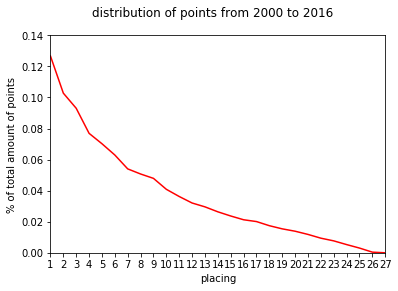

In [87]:
import matplotlib.pyplot as plt

ESC_1957_61, ESC_1962_66, ESC_1967_75, ESC_1975_2015, ESC_2016_19 = reimport_data()
all_ESCs = {**ESC_1957_61 , **ESC_1962_66, **ESC_1967_75, **ESC_1975_2015, **ESC_2016_19}

l = [str(i) for i in range(2000,2016)]
ESC_2000_15 = dict([(key, all_ESCs[key]) for key in l])
# check_collusion(ESC_1960_80, ['gb', 'fr'])

points = [0 for i in range(27)]
for esc in ESC_2000_15:
    result = ESC_2000_15[esc].compute_result()
    rank = 0
    for element in sorted(result, key=result.get, reverse=True):
        points[rank] += result[element]
        rank += 1
for i in range(27):
    points[i] = points[i]/33466
    
print(points)
    
plt.plot(range(1,28), points, 'r-')
plt.axis([1,27,0,0.14])
plt.xticks(range(1,28))
plt.xlabel("placing")
plt.ylabel("% of total amount of points")
plt.suptitle('distribution of points from 2000 to 2016')
plt.show()


# points = [0 for i in range(20)]
# for esc in ESC_1960_80:
#     result = ESC_1960_80[esc].compute_result()
#     rank = 0
#     for element in sorted(result, key=result.get, reverse=True):
#         points[rank] += result[element]
#         rank += 1
# for i in range(20):
#     points[i] = points[i]/11865
# print(points)
    
# plt.plot(range(1,21), points, 'r-')
# plt.axis([1,20,0,0.14])
# plt.xticks(range(1,21))
# plt.xlabel("Placing")
# plt.ylabel("% of total amount of points")
# plt.suptitle('distribution of points from 1960 to 1980')
# plt.show()

# points = [0 for i in range(25)]
# for esc in ESC_1980_00:
#     result = ESC_1980_00[esc].compute_result()
#     rank = 0
#     for element in sorted(result, key=result.get, reverse=True):
#         points[rank] += result[element]
#         rank += 1
# for i in range(25):
#     points[i] = points[i]/25288
    
# print(points)
    
# plt.plot(range(1,26), points, 'r-')
# plt.axis([1,25,0,0.14])
# plt.xticks(range(1,26))
# plt.xlabel("placing")
# plt.ylabel("% of total amount of points")
# plt.suptitle('distribution of points from 1980 to 2000')
# plt.show()




# l = [str(i) for i in range(1980,2000)]
# ESC_1980_2000 = dict([(key, all_ESCs[key]) for key in l])
# check_collusion(ESC_1980_2000, ['dk', 'is'])

# l = [str(i) for i in range(2000,2016)]
# ESC_2000_2016 = dict([(key, all_ESCs[key]) for key in l])
# check_collusion(ESC_2000_2016, ['no', 'se'])

In [12]:
# placeholder